# Logistic Regression Project

Given the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic), I will build a model that will predict what type of passanger would be likely to survive the sinking.

Lets get started!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('titanic_train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Cleaning Our Data

Firstly we shall check if our data has any irregularities or any null values.

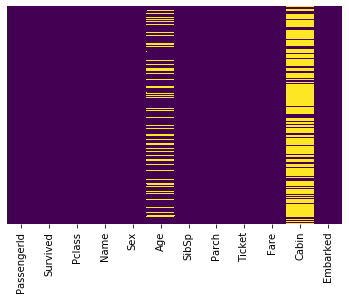

In [5]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

From the heatmap, we can see that a lot of the cabin data is missing along with some of our age data as well.
I will thus try to clean this data, either by dropping the missing columns or by using other columns(like passenger class or fare price) to estimate a rough age. 
We should try our best to keep the age column with even this roughly assumed data as age did play a vital role in survival of the passangers.

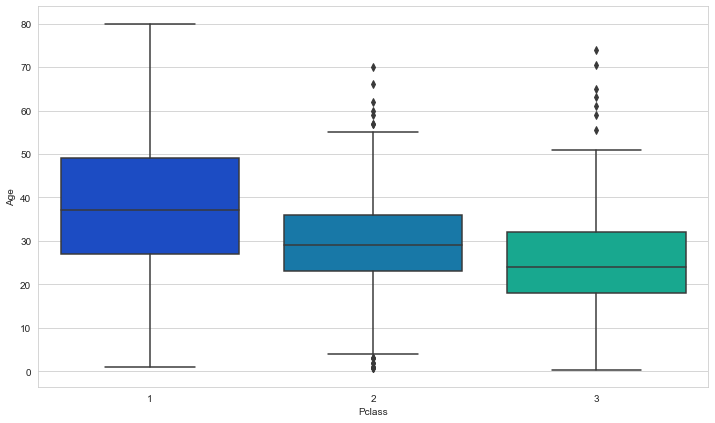

In [6]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

From the boxplot we can assume that passangers with higher class tickets tend to be older than other passangers. I will thus use these average ages and replace where we find null values.

In [7]:
def replace_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

In [8]:
train['Age'] = train[['Age','Pclass']].apply(replace_age,axis=1)

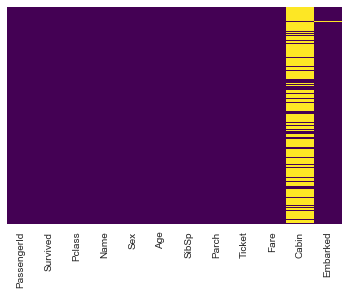

In [9]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

There we go! Age column is clean. Now we can drop cabin column as it is not in a binary sort of format and it wont be really useful for our model.
All thats left is to fix the small NAN values in embarked.

In [10]:
train.drop('Cabin',axis=1,inplace=True)
train.dropna(inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


## Converting Categorical features

The model will not be able to recognise categorical features like sex and embarked columns. We will thus have to convert them to binary

In [11]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [12]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True) #we have no need for these columns for our algorithm 

In [13]:
train = pd.concat([train,sex,embark],axis=1)

In [14]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


We have our ideal data set which we can use for our algorithm. Now lets do some anlaysis on this data set and see if there is any room for improvement and how we will go on about our model.

## Data Analysis

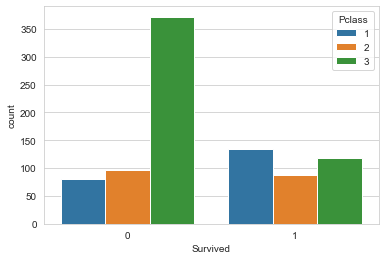

In [15]:
sns.countplot(x='Survived',hue='Pclass',data=train)

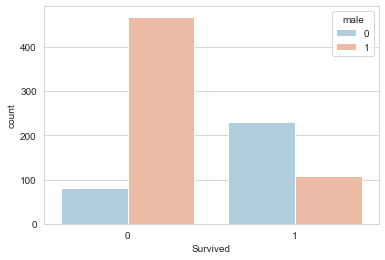

In [16]:
sns.countplot(x='Survived',hue='male',data=train,palette='RdBu_r')

Male to female survival rate 

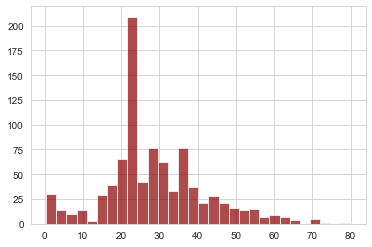

In [17]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

Range of ages on the Titanic

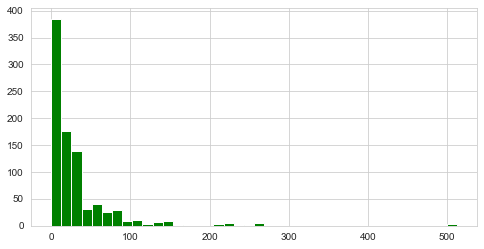

In [18]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

## Building Our Model

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [35]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

In [36]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
predictions = logmodel.predict(X_test)

## Evaluation

In [40]:
from sklearn.metrics import classification_report,confusion_matrix

In [39]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86       163
           1       0.85      0.65      0.74       104

    accuracy                           0.82       267
   macro avg       0.83      0.79      0.80       267
weighted avg       0.82      0.82      0.81       267



In [41]:
print(confusion_matrix(y_test,predictions))

[[151  12]
 [ 36  68]]


There we go! We have a pretty good model. Thank you to anyone who had a look at my attempt at this project.